# Trabajo Práctico Integrador - Analisis de Datos

## Introducción
En este trabajo práctico, aplicamos las técnicas vistas en clase con un objetivo claro: explorar, limpiar y preparar un conjunto de datos reales. El fin último es sentar las bases para plantear un problema de aprendizaje supervisado.

### Nuestro Equipo:
- Maximiliano Christener
- Luis Diaz Charris
- Mariano Fagre
- Juan Pablo Skobalski
- Ronald Uthurralt

### El Dataset:
Para este análisis, seleccionamos el UCDP Georeferenced Event Dataset (GED) Global versión 25.1, un set de datos provisto por el Uppsala Conflict Data Program (UCDP).

Elegimos este conjunto de datos por su gran detalle. Contiene información georreferenciada sobre eventos de violencia organizada que han ocurrido en todo el mundo desde 1989. Cada registro no es solo un número, sino que representa un evento violento individual, describiendo su fecha, ubicación precisa (latitud y longitud), el tipo de violencia (conflicto estatal, no estatal o unilateral), quiénes fueron los actores involucrados y una estimación de las víctimas fatales, entre otros atributos.

Lo valioso de estos datos es que nos permiten explorar fenómenos muy complejos, como los conflictos armados y la violencia política, desde dos ángulos clave: temporalmente (cómo ha evolucionado la violencia) y espacialmente (dónde se concentran).

## Nuestra Hipótesis y Objetivos
Tras una primera exploración de los datos, formulamos la siguiente hipótesis de trabajo:

### DISUCTAMOS SI CORRESPONDE O NO, SOLO LO ESCRIBO CON EL OBJETIVO DE ESTRUCTURAR EL DOCUMENTO
Hipótesis: Creemos que ciertos factores estructurales, como el tipo de violencia, la región geográfica y los actores involucrados, influyen de manera significativa en el nivel de letalidad (es decir, la cantidad de víctimas fatales) de un conflicto.

Basados en esta idea, nuestros objetivos para este trabajo son:

1. Analizar las características generales del dataset, entendiendo su distribución tanto geográfica como temporal.

2. Identificar si existen patrones de violencia claros según el tipo de evento, la región o los actores.

3. Preparar el conjunto de datos para un posible modelo de aprendizaje supervisado. Aquí, nuestra variable objetivo será best_est (la cantidad estimada de víctimas), con la que buscaremos predecir la letalidad de un evento basándonos en sus características.



### Otra posible hipótesis

**H2. La duración de un conflicto puede predecirse a partir del tipo violencia y el tipo de actores involucrados, cantidad acumulada de víctimas y la ubicación del conflicto.**

 - Esto implica: 
    - Crear un nuevo dataset que agrupe los datos por conflicto. 
    - Antes de crear este nuevo dataset, tendremos que purificar el dataset para no traernos errores (ya que tendremos que sumar, promediar, etc.).
    - Luego, con la hipótesis en mente estandarizar, reducir dimensionalidad, graficar... 



# EDA (Análisis Exploratorio de los Datos)

#### Cargar el Dataset

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder

#Esta libreria son para el heat map, me parecio copada, pero puede haber otras
import folium
from folium.plugins import HeatMap



In [52]:
df = pd.read_csv("data/GEDEvent_v25_1.csv", low_memory=False)

df.head(3)

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,high,low,gwnoa,gwnob
0,244657,IRQ-2017-1-524-322,2017,True,Clear,1,259,259,Iraq: Government,524,...,2017-07-31 00:00:00.000,0,4,0,2,6,6,6,645,NaN
1,412700,IRQ-2021-1-524-145,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-26 00:00:00.000,13,1,141,28,183,184,171,645,NaN
2,413023,IRQ-2021-1-524-143,2021,True,Clear,1,259,259,Iraq: Government,524,...,2021-08-28 00:00:00.000,0,2,0,0,2,3,0,645,NaN


In [53]:
print(f"Número de observaciones: {df.shape[0]}")
print(f"Número de variables: {df.shape[1]}")

df.info()

Número de observaciones: 385918
Número de variables: 49
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385918 entries, 0 to 385917
Data columns (total 49 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 385918 non-null  int64  
 1   relid              385918 non-null  object 
 2   year               385918 non-null  int64  
 3   active_year        385918 non-null  bool   
 4   code_status        385918 non-null  object 
 5   type_of_violence   385918 non-null  int64  
 6   conflict_dset_id   385918 non-null  int64  
 7   conflict_new_id    385918 non-null  int64  
 8   conflict_name      385918 non-null  object 
 9   dyad_dset_id       385918 non-null  int64  
 10  dyad_new_id        385918 non-null  int64  
 11  dyad_name          385918 non-null  object 
 12  side_a_dset_id     385918 non-null  int64  
 13  side_a_new_id      385918 non-null  int64  
 14  side_a             385918 non-null  object 


In [54]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
385913    False
385914    False
385915    False
385916    False
385917    False
Length: 385918, dtype: bool

In [55]:
# Se crea un dataframe como resumen de las característics de las variables. 

df_resumen = pd.DataFrame({
    'variable_name': df.columns,
    'dtype': df.dtypes.astype(str),
    'no nulos': df.count(),
    'unicos': df.nunique(),
    'unicos_%': (df.nunique()/df.count()*100).round(0).astype(int),
    'nulos': df.isna().sum(),
    'nulos_%': (df.isna().mean() * 100).round(0).astype(int),

})
df_resumen.reset_index(drop=True, inplace=True)

In [56]:
# Leemos el csv con la descripción de las variables y un primer filtro de columnas a dropear
variables = pd.read_csv("data/variable_names_and_descriptions_v2.csv", encoding="utf-8", sep=";")



In [57]:
# Mergeamos los dos df
df_resumen = df_resumen.merge(variables, on="variable_name", how="left")
df_resumen = df_resumen.fillna('')




In [58]:
df_resumen

,variable_name,dtype,no nulos,unicos,unicos_%,nulos,nulos_%,description,eliminate,type,comment
0,id,int64,385918,385918,100,0,0,Identificador unico del evento,True,,"No aporta info, además está depregado"
1,relid,object,385918,385918,100,0,0,Identificador interno del evento (cambia si el...,True,,No aporta info
2,year,int64,385918,36,0,0,0,Ano del evento,False,Date,
3,active_year,bool,385918,2,0,0,0,True si el evento pertenece a un conflicto act...,False,Int,
4,code_status,object,385918,1,0,0,0,Si el registro est ok (clear) o si hay que ch...,True,,"Solo tiene clear, siempre es clear segun del c..."
5,type_of_violence,int64,385918,3,0,0,0,"Tipo de violencia: 1. Conflicto entre estados,...",False,Nom,
6,conflict_dset_id,int64,385918,1484,0,0,0,Identificador deprecado,True,,Deprecado
7,conflict_new_id,int64,385918,1531,0,0,0,Identificador único del conflicto (usar esto p...,False,Nom,puede servir para agrupar eventos por conflic...
8,conflict_name,object,385918,1529,0,0,0,Nombre del conflicto,False,Nom,
9,dyad_dset_id,int64,385918,1740,0,0,0,Identificador deprecado,True,,Deprecado


          best      high       low
best  1.000000  0.833601  0.927437
high  0.833601  1.000000  0.721497
low   0.927437  0.721497  1.000000


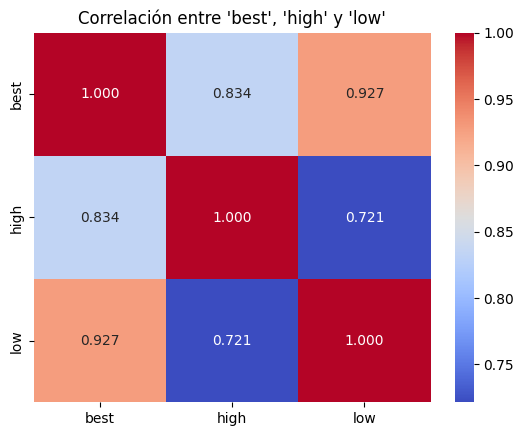

In [ ]:
# Se realiza un análisis de correlación entre las variables "best", "high" y "low", 
# para ver la posibilidad de descartar alguna de ellas, porque, a priori, se cree que 
# pueden estar fuertemente correlacionadas.

cols_to_correlate = ["best", "high", "low"]
corr_matrix = df[cols_to_correlate].corr()

print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlación entre 'best', 'high' y 'low'")
plt.show()

### Análisis y justificación de las variables a eliminar


A continuación, se presenta una justificación técnica y empírica para la eliminación de algunas variables del dataset, basada en:

- Evidencia observada en los datos.

- Relevancia conceptual frente a la hipótesis $H_{1}$ y $H_{2}$.

- Pertinencia para modelos de machine learning.


| Variable              | Justificación de eliminación |
|------------------------|------------------------------|
| **id** | Se elimina por ser un identificador único sin valor analítico. No aporta información adicional y, además, se encuentra deprecado en la versión actual del conjunto de datos. |
| **relid** | Corresponde a un identificador interno que cambia entre versiones del dataset. No es estable ni aporta valor analítico, por lo que se excluye. |
| **code_status** | Contiene un único valor (“clear”) en todos los registros, lo que implica ausencia de variabilidad e inutilidad estadística. |
| **conflict_dset_id** | Campo deprecado según la documentación del conjunto de datos; reemplazado por `conflict_new_id`. |
| **dyad_dset_id** | Identificador obsoleto, reemplazado por `dyad_new_id`. No aporta valor agregado al análisis. |
| **dyad_new_id** | Aunque identifica diadas únicas, se elimina para simplificar el análisis posterior (hipótesis H2) y evitar redundancias con los nombres de los participantes (`side_a` y `side_b`). |
| **side_a_dset_id** | Campo deprecado que no se usa actualmente; reemplazado por `side_a_new_id`. |
| **side_a_new_id** | Se elimina para los análisis orientados a H2, ya que la información se conserva en la variable nominal `side_a`. |
| **side_b_dset_id** | Variable obsoleta reemplazada por `side_b_new_id`; no tiene utilidad en el modelo. |
| **side_b_new_id** | Se elimina por las mismas razones que `side_a_new_id`: redundancia con el nombre del participante. |
| **number_of_sources** | Aunque cuantitativa, no tiene relación directa con las variables de interés del análisis propuesto y puede introducir ruido. |
| **source_article** | Contiene información textual extensa (títulos, fechas, nombres de fuentes) que requiere un procesamiento de texto especializado y no aporta valor directo al análisis cuantitativo. |
| **source_office** | Presenta un 25% de valores nulos y solo contiene información relevante hasta 2013. Su eliminación evita sesgos temporales. |
| **source_date** | Aunque es una fecha, su correspondencia con la publicación de la fuente no es relevante para los objetivos analíticos. Se excluye por irrelevancia contextual. |
| **source_headline** | Texto descriptivo no estructurado sin utilidad para los análisis cuantitativos previstos. |
| **source_original** | Información redundante sobre la fuente primaria de datos; no aporta información estadística significativa. |
| **where_prec** | Variable ordinal sobre precisión geográfica. Se elimina por no ser relevante en el análisis de hipótesis H2. |
| **where_coordinates** | Representa ubicaciones textuales redundantes con las coordenadas numéricas (`latitude`, `longitude`). Se elimina para evitar duplicidad. |
| **where_description** | Campo textual de comentarios sin estructura, que no contribuye al análisis estadístico. |
| **adm_1** | Aunque aporta contexto geográfico, esta información ya está representada de forma más precisa por las coordenadas (latitude, longitude) y la variable country. Mantenerla implicaría redundancia espacial y un incremento innecesario de dimensionalidad. Se elimina para optimizar la consistencia geográfica y reducir la multicolinealidad espacial. |
| **adm_2** | Presenta un 18 % de valores nulos y una alta cardinalidad (más de 9 000 valores únicos), lo que dificulta su uso en modelos sin una normalización adicional. Además, la granularidad local no es esencial para el nivel de análisis propuesto, centrado en tendencias de conflicto y no en microdinámicas territoriales. Por tanto, se elimina para evitar ruido y complejidad innecesaria. |
| **geom_wkt** | Representación geométrica redundante, derivable de `latitude` y `longitude`; su inclusión no agrega valor. |
| **priogrid_gid** | Identificador de celdas geográficas redundante con las coordenadas. Su eliminación no afecta la integridad espacial del dataset. |
| **country_id** | Duplicado funcional de `country`; mantener ambos introduce redundancia. Se conserva únicamente el nombre del país. |
| **event_clarity** | Variable ordinal binaria sobre la claridad del evento. Se elimina porque no incide en los indicadores de violencia ni aporta diferenciación útil. |
| **date_prec** | Describe la precisión de la fecha pero no el evento en sí. No es necesaria para los análisis temporales, dado que `date_start` y `date_end` ya contienen la información relevante. |
| **"high" y "low"** | Tras el análisis de correlación entre las variables best, high y low, se identificaron coeficientes elevados (r = 0.83–0.93), lo que evidencia una fuerte dependencia lineal entre ellas. Conceptualmente, las tres variables describen la estimación de muertes en un evento, con diferentes grados de certeza. Dado que best representa la estimación central y condensa la variabilidad principal del conjunto, se decide conservar únicamente esta variable. Las variables high y low se eliminan por redundancia informativa y para reducir la colinealidad en etapas posteriores del modelado. |
| **gwnoa** | Identificador codificado del participante A sin relevancia conceptual para los objetivos propuestos. |
| **gwnob** | Presenta 92% de valores nulos, lo que impide su aprovechamiento analítico. Se elimina por baja completitud y escasa utilidad. |


### Se procede a eliminar del dataset las columnas que aportan poca información según el análisis previo 

In [61]:
cols_to_drop = [
    "id",
    "relid",
    "code_status",
    "conflict_dset_id",
    "dyad_dset_id",
    "dyad_new_id",
    "side_a_dset_id",
    "side_a_new_id",
    "side_b_dset_id",
    "side_b_new_id",
    "number_of_sources",
    "source_article",
    "source_office",
    "source_date",
    "source_headline",
    "source_original",
    "where_prec",
    "where_coordinates",
    "where_description",
    "adm_1",
    "adm_2",
    "geom_wkt",
    "priogrid_gid",
    "country_id",
    "event_clarity",
    "date_prec",
    "high",
    "low",
    "gwnoa",
    "gwnob"
]

df_2 = df.drop(columns=cols_to_drop, errors="ignore")

# Se guarda el nuevo dataframe en un archivo CSV
df_2.to_csv("./data/GED_event_dataset_2_cut.csv", index=False)



In [62]:
df_2.head(5)


,year,active_year,type_of_violence,conflict_new_id,conflict_name,dyad_name,side_a,side_b,latitude,longitude,country,region,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best
0,2017,True,1,259,Iraq: Government,Government of Iraq - IS,Government of Iraq,IS,34.531094,69.162796,Afghanistan,Asia,2017-07-31 00:00:00.000,2017-07-31 00:00:00.000,0,4,0,2,6
1,2021,True,1,259,Iraq: Government,Government of Iraq - IS,Government of Iraq,IS,34.564444,69.217222,Afghanistan,Asia,2021-08-26 00:00:00.000,2021-08-26 00:00:00.000,13,1,141,28,183
2,2021,True,1,259,Iraq: Government,Government of Iraq - IS,Government of Iraq,IS,34.428844,70.455750,Afghanistan,Asia,2021-08-28 00:00:00.000,2021-08-28 00:00:00.000,0,2,0,0,2
3,2021,True,1,259,Iraq: Government,Government of Iraq - IS,Government of Iraq,IS,34.531094,69.162796,Afghanistan,Asia,2021-08-29 00:00:00.000,2021-08-29 00:00:00.000,0,0,10,0,10
4,1989,True,1,333,Afghanistan: Government,Government of Afghanistan - Jam'iyyat-i Islami...,Government of Afghanistan,Jam'iyyat-i Islami-yi Afghanistan,34.333330,70.416670,Afghanistan,Asia,1989-01-07 00:00:00.000,1989-01-13 00:00:00.000,6,0,0,0,6


In [63]:
df_2.describe().T

,count,mean,std,min,25%,50%,75%,max
year,385918.0,2012.488513,9.408420,1989.000000,2007.000000,2014.00000,2020.000000,2024.000000
type_of_violence,385918.0,1.451370,0.746014,1.000000,1.000000,1.00000,2.000000,3.000000
conflict_new_id,385918.0,3893.462945,5774.828401,205.000000,299.000000,386.00000,4979.000000,16527.000000
latitude,385918.0,26.094948,16.048457,-37.813611,13.356770,33.00000,35.784268,68.979170
longitude,385918.0,29.653143,49.506979,-117.300000,29.171058,37.05324,62.200001,155.896681
deaths_a,385918.0,2.470660,254.720238,0.000000,0.000000,0.00000,0.000000,121848.000000
deaths_b,385918.0,2.245581,53.764628,0.000000,0.000000,0.00000,1.000000,19874.000000
deaths_civilians,385918.0,3.819710,178.402817,0.000000,0.000000,0.00000,1.000000,40000.000000
deaths_unknown,385918.0,1.717893,99.617277,0.000000,0.000000,0.00000,0.000000,48183.000000
best,385918.0,10.253844,347.680699,0.000000,1.000000,2.00000,4.000000,121848.000000


In [64]:
df_2_resumen = pd.DataFrame({
    'variable_name': df_2.columns,
    'dtype': df_2.dtypes.astype(str),
    'no nulos': df_2.count(),
    'unicos': df_2.nunique(),
    'unicos_%': (df_2.nunique()/df_2.count()*100).round(0).astype(int),
    'nulos': df_2.isna().sum(),
    'nulos_%': (df_2.isna().mean() * 100).round(0).astype(int),

})
df_2_resumen.reset_index(drop=True, inplace=True)

In [65]:
df_2_resumen = df_2_resumen.fillna('')

df_2_resumen

,variable_name,dtype,no nulos,unicos,unicos_%,nulos,nulos_%
0,year,int64,385918,36,0,0,0
1,active_year,bool,385918,2,0,0,0
2,type_of_violence,int64,385918,3,0,0,0
3,conflict_new_id,int64,385918,1531,0,0,0
4,conflict_name,object,385918,1529,0,0,0
5,dyad_name,object,385918,1771,0,0,0
6,side_a,object,385918,966,0,0,0
7,side_b,object,385918,959,0,0,0
8,latitude,float64,385918,52516,14,0,0
9,longitude,float64,385918,53330,14,0,0


## Notas

Creo que las variables `deaths_a`, `deaths_b`, `deaths_civilians`, `deaths_unknown` y `best`, son todas posibles salidas de un modelo. Es decir variables que podemos llegar a predecir dadas las demás. 

Considero que en dicho caso, se consideren como targets todas estas. Más allá de si se llega a implementar algún modelo después de terminada la cursada de la materia. 

Lo que se pueda hacer después de esto, dependerá de por cuál de las dos hipótesis nos decantemos, así, enfocamos el tratamietno de los datos según el problema que elijamos resolver. 


In [ ]:
# Se convierten en formato fecha las variables que representan este tipo de datos

for c in ["source_date", "date_start", "date_end"]:
    if c in df.columns:
        df_2[c] = pd.to_datetime(df[c], errors='coerce')

# Se crea una nueva columna que contiene la duración del conflicto en días
df["event_duration_days"] = (df["date_end"] - df["date_start"]).dt.days

# Referencias

[1] Davies, S., Pettersson, T., Sollenberg, M., & Öberg, M. (2025). Organized violence 1989–2024, and the challenges of identifying civilian victims. Journal of Peace Research, 62(4).

[2] Sundberg, Ralph and Erik Melander (2013) Introducing the UCDP Georeferenced Event Dataset. Journal of Peace Research 50(4).

[3] UCDP is part of and funded by DEMSCORE, national research infrastructure grant 2021-00162 from the Swedish Research Council.